# Summary
- Spearmans of neuron rankings improve with higher layers
- Lower layers of xlnet large actually are similar to higher layers of bert large. 
- Final four layers of bert large are quite different from the rest. Weird, because architecturally nothing has changed.

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [6]:
method_l = [
    "maxcorr", 
    "mincorr", 
    "maxlinreg", 
    "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [7]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["maxcorr"]["corrs"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["maxcorr"]["corrs"][network].values()))) # god this is a hack

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [8]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [9]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [10]:
res_d["mincorr"]["neuron_sort"]

{'bert_large_cased-ptb_pos_dev.hdf5_0': [16,
  521,
  809,
  511,
  783,
  58,
  896,
  492,
  94,
  2,
  318,
  208,
  38,
  76,
  287,
  761,
  413,
  784,
  156,
  179,
  277,
  482,
  842,
  99,
  379,
  69,
  246,
  319,
  226,
  565,
  305,
  765,
  307,
  273,
  826,
  816,
  634,
  25,
  449,
  789,
  865,
  991,
  997,
  854,
  567,
  389,
  284,
  554,
  600,
  563,
  450,
  877,
  225,
  864,
  597,
  220,
  408,
  205,
  544,
  361,
  640,
  302,
  265,
  532,
  602,
  520,
  354,
  132,
  618,
  667,
  691,
  151,
  209,
  665,
  342,
  338,
  928,
  137,
  79,
  42,
  264,
  518,
  571,
  882,
  233,
  437,
  703,
  845,
  399,
  545,
  483,
  123,
  1001,
  193,
  929,
  658,
  839,
  425,
  1015,
  772,
  343,
  886,
  258,
  846,
  432,
  168,
  1018,
  218,
  92,
  875,
  314,
  965,
  625,
  760,
  436,
  536,
  206,
  104,
  423,
  426,
  298,
  471,
  889,
  454,
  861,
  961,
  709,
  680,
  384,
  494,
  230,
  599,
  786,
  1002,
  375,
  397,
  86,
  979,
  172

In [11]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [12]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased-ptb_pos_dev.hdf5_0
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.176786   0.841955 -0.265459
maxlinreg  0.176786   1.000000   0.267580  0.648590
minlinreg  0.841955   0.267580   1.000000 -0.205276
maxcorr   -0.265459   0.648590  -0.205276  1.000000
bert_large_cased-ptb_pos_dev.hdf5_1
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.035100   0.745113 -0.017520
maxlinreg  0.035100   1.000000   0.278006  0.966641
minlinreg  0.745113   0.278006   1.000000  0.214889
maxcorr   -0.017520   0.966641   0.214889  1.000000
bert_large_cased-ptb_pos_dev.hdf5_2
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.131423   0.741115  0.115594
maxlinreg  0.131423   1.000000   0.450775  0.977873
minlinreg  0.741115   0.450775   1.000000  0.434118
maxcorr    0.115594   0.977873   0.434118  1.000000
bert_large_cased-ptb_pos_dev.hdf5_3
            mincorr  maxlinreg  minlinreg   maxcorr
mincorr    1.000000   0.

### Distributions

In [13]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased-ptb_pos_dev.hdf5_0:

mincorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_1                  981
bert_base_cased-ptb_pos_dev.hdf5_0                    40
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      2
openai_transformer-ptb_pos_dev.hdf5_2                  1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23    687
elmo_4x4096_512-ptb_pos_dev.hdf5_2        67
xlnet_large_cased-ptb_pos_dev.hdf5_20     50
xlnet_large_cased-ptb_pos_dev.hdf5_22     34
xlnet_large_cased-ptb_pos_dev.hdf5_16     32
xlnet_large_cased-ptb_pos_dev.hdf5_19     26
xlnet_large_cased-ptb_pos_dev.hdf5_21     20
xlnet_large_cased-ptb_pos_dev.hdf5_17     19
xlnet_large_cased-ptb_pos_dev.hdf5_18     19
xlnet_large_cased-ptb_pos_dev.hdf5_15     18
xlnet_large_cased-ptb_pos_dev.hdf5_13      9
elmo_4x4096_512-ptb_pos_dev.hdf5_3         9
xlnet_large_cased-ptb_pos_dev.hdf5_14      4
xlnet_large_cased-ptb_pos_dev.hdf5_12      3
bert_base_cased-ptb_pos_dev.hdf5_8         3
bert_large_cas


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_3    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                935
openai_transformer-ptb_pos_dev.hdf5_12                37
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    31
elmo_original-ptb_pos_dev.hdf5_0                      11
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      9
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.450775  0.713182
min  0.450775  1.000000  0.880766
med  0.713182  0.880766  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_3    1013
bert_large_cased-ptb_pos_dev.hdf5_1      11
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                564
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    61
xlnet_large_cased-ptb_pos_dev.hdf5_22                 56
xlnet_large_cased-ptb_pos_dev.hdf5_20                 46
xlnet_large_cased-ptb_pos_dev.hdf5_16                 40

bert_large_cased-ptb_pos_dev.hdf5_6    703
bert_large_cased-ptb_pos_dev.hdf5_4    321
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                590
xlnet_large_cased-ptb_pos_dev.hdf5_22                 50
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    47
xlnet_large_cased-ptb_pos_dev.hdf5_20                 37
xlnet_large_cased-ptb_pos_dev.hdf5_16                 34
xlnet_large_cased-ptb_pos_dev.hdf5_15                 31
xlnet_large_cased-ptb_pos_dev.hdf5_19                 26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    20
xlnet_large_cased-ptb_pos_dev.hdf5_14                 20
xlnet_large_cased-ptb_pos_dev.hdf5_17                 18
xlnet_large_cased-ptb_pos_dev.hdf5_18                 18
xlnet_large_cased-ptb_pos_dev.hdf5_13                 17
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    13
xlnet_large_cased-ptb_pos_dev.hdf5_21                 13
xlnet_large_cased-ptb_pos_dev.hdf5_12                 10
elmo_4x4096_512-ptb_pos_dev.hdf5_0 

          max       min       med
max  1.000000  0.578564  0.773455
min  0.578564  1.000000  0.917214
med  0.773455  0.917214  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_6                  744
bert_large_cased-ptb_pos_dev.hdf5_8                  279
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                640
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    44
xlnet_large_cased-ptb_pos_dev.hdf5_22                 38
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    34
xlnet_large_cased-ptb_pos_dev.hdf5_20                 26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 26
xlnet_large_cased-ptb_pos_dev.hdf5_16                 23
xlnet_large_cased-ptb_pos_dev.hdf5_19                 20
xlnet_large_cased-ptb_pos_dev.hdf5_21                 18
xlnet_large_cased-ptb_pos_dev.hdf5_17                 16
xlnet_large_cased-ptb_pos_dev.hdf5_14                 14
xlnet_large_cased-ptb_

xlnet_large_cased-ptb_pos_dev.hdf5_23                580
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    43
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    42
xlnet_large_cased-ptb_pos_dev.hdf5_22                 32
xlnet_large_cased-ptb_pos_dev.hdf5_16                 29
xlnet_large_cased-ptb_pos_dev.hdf5_20                 29
xlnet_large_cased-ptb_pos_dev.hdf5_19                 20
xlnet_large_cased-ptb_pos_dev.hdf5_18                 19
xlnet_large_cased-ptb_pos_dev.hdf5_15                 18
openai_transformer-ptb_pos_dev.hdf5_12                18
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    17
elmo_original-ptb_pos_dev.hdf5_0                      16
xlnet_large_cased-ptb_pos_dev.hdf5_13                 15
xlnet_large_cased-ptb_pos_dev.hdf5_17                 13
xlnet_large_cased-ptb_pos_dev.hdf5_14                 12
xlnet_large_cased-ptb_pos_dev.hdf5_21                 12
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    11
elmo_original-ptb_pos_dev.hdf5_

          max       min       med
max  1.000000  0.738814  0.872153
min  0.738814  1.000000  0.942539
med  0.872153  0.942539  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_11                 822
bert_large_cased-ptb_pos_dev.hdf5_13                 201
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                620
xlnet_large_cased-ptb_pos_dev.hdf5_22                 53
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    36
xlnet_large_cased-ptb_pos_dev.hdf5_20                 26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    24
openai_transformer-ptb_pos_dev.hdf5_12                19
xlnet_large_cased-ptb_pos_dev.hdf5_19                 18
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
xlnet_large_cased-ptb_pos_dev.hdf5_16                 15
xlnet_large_cased-ptb_pos_dev.hdf5_18                 14
openai_transformer-ptb_pos_dev.hdf5_0                 13
elmo_original-ptb_pos_

bert_large_cased-ptb_pos_dev.hdf5_16    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   400
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    217
openai_transformer-ptb_pos_dev.hdf5_12               206
elmo_original-ptb_pos_dev.hdf5_0                     137
openai_transformer-ptb_pos_dev.hdf5_0                 37
xlnet_large_cased-ptb_pos_dev.hdf5_23                 14
xlnet_large_cased-ptb_pos_dev.hdf5_0                  10
bert_base_cased-ptb_pos_dev.hdf5_0                     2
openai_transformer-ptb_pos_dev.hdf5_1                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.876176  0.916833
min  0.876176  1.000000  0.954015
med  0.916833  0.954015  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_16    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   400
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    217
openai_transformer-ptb_pos_dev.hdf5_12            

bert_large_cased-ptb_pos_dev.hdf5_16    561
bert_large_cased-ptb_pos_dev.hdf5_18    463
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                527
elmo_original-ptb_pos_dev.hdf5_0                      53
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    48
openai_transformer-ptb_pos_dev.hdf5_0                 42
xlnet_large_cased-ptb_pos_dev.hdf5_1                  38
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    36
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    32
xlnet_large_cased-ptb_pos_dev.hdf5_22                 25
openai_transformer-ptb_pos_dev.hdf5_1                 21
xlnet_large_cased-ptb_pos_dev.hdf5_2                  20
openai_transformer-ptb_pos_dev.hdf5_12                15
xlnet_large_cased-ptb_pos_dev.hdf5_0                  11
xlnet_large_cased-ptb_pos_dev.hdf5_21                 11
elmo_original-ptb_pos_dev.hdf5_2                      10
bert_base_cased-ptb_pos_dev.hdf5_0                     9
bert_large_cased-ptb_pos_dev.hdf5

elmo_4x4096_512-ptb_pos_dev.hdf5_0                   561
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    152
openai_transformer-ptb_pos_dev.hdf5_12               122
elmo_original-ptb_pos_dev.hdf5_0                     108
openai_transformer-ptb_pos_dev.hdf5_0                 70
xlnet_large_cased-ptb_pos_dev.hdf5_23                  5
openai_transformer-ptb_pos_dev.hdf5_1                  2
xlnet_large_cased-ptb_pos_dev.hdf5_0                   2
bert_base_cased-ptb_pos_dev.hdf5_0                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.782326  0.840162
min  0.782326  1.000000  0.932758
med  0.840162  0.932758  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_19    991
bert_large_cased-ptb_pos_dev.hdf5_21     33
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   561
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    152
openai_transformer-ptb_pos_dev.hdf5_12               122
elmo_original-ptb_p

elmo_4x4096_512-ptb_pos_dev.hdf5_0                   497
openai_transformer-ptb_pos_dev.hdf5_12               166
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    162
elmo_original-ptb_pos_dev.hdf5_0                     134
openai_transformer-ptb_pos_dev.hdf5_0                 56
xlnet_large_cased-ptb_pos_dev.hdf5_23                  6
openai_transformer-ptb_pos_dev.hdf5_1                  1
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
bert_base_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.757284  0.837469
min  0.757284  1.000000  0.929660
med  0.837469  0.929660  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_22    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   497
openai_transformer-ptb_pos_dev.hdf5_12               166
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    162
elmo_original-ptb_pos_dev.hdf5_0                     134
opena


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_22    1023
bert_large_cased-ptb_pos_dev.hdf5_24       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23    345
elmo_4x4096_512-ptb_pos_dev.hdf5_2        81
elmo_original-ptb_pos_dev.hdf5_0          68
elmo_4x4096_512-ptb_pos_dev.hdf5_0        58
xlnet_large_cased-ptb_pos_dev.hdf5_2      45
                                        ... 
openai_transformer-ptb_pos_dev.hdf5_8      1
xlnet_large_cased-ptb_pos_dev.hdf5_4       1
openai_transformer-ptb_pos_dev.hdf5_6      1
bert_base_cased-ptb_pos_dev.hdf5_5         1
bert_large_cased-ptb_pos_dev.hdf5_6        1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.344936  0.348079
min  0.344936  1.000000  0.839074
med  0.348079  0.839074  1.000000


bert_large_cased-ptb_pos_dev.hdf5_24:

mincorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_23     1016
openai_transformer-ptb_pos_dev.hdf5_6       3
bert_large_cased-ptb_pos_dev.hdf5_21        2
xlnet_l

          max       min       med
max  1.000000 -0.170870 -0.222773
min -0.170870  1.000000  0.910625
med -0.222773  0.910625  1.000000

maxlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_1    760
xlnet_large_cased-ptb_pos_dev.hdf5_1       4
openai_transformer-ptb_pos_dev.hdf5_2      2
bert_large_cased-ptb_pos_dev.hdf5_0        1
xlnet_large_cased-ptb_pos_dev.hdf5_0       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                756
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
elmo_original-ptb_pos_dev.hdf5_0                       4
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      2
elmo_4x4096_512-ptb_pos_dev.hdf5_4                     1
openai_transformer-ptb_pos_dev.hdf5_12                 1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.292286  0.367033
min  0.292286  1.000000  0.933603
med  0.367033  0.933603  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_1    760
xlnet_large_cased-ptb

openai_transformer-ptb_pos_dev.hdf5_4    415
openai_transformer-ptb_pos_dev.hdf5_2    353
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                401
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    47
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    42
xlnet_large_cased-ptb_pos_dev.hdf5_22                 31
elmo_original-ptb_pos_dev.hdf5_2                      21
xlnet_large_cased-ptb_pos_dev.hdf5_15                 21
bert_base_cased-ptb_pos_dev.hdf5_12                   20
xlnet_large_cased-ptb_pos_dev.hdf5_20                 20
xlnet_large_cased-ptb_pos_dev.hdf5_13                 19
xlnet_large_cased-ptb_pos_dev.hdf5_16                 18
xlnet_large_cased-ptb_pos_dev.hdf5_14                 14
bert_large_cased-ptb_pos_dev.hdf5_24                  14
xlnet_large_cased-ptb_pos_dev.hdf5_21                 12
xlnet_large_cased-ptb_pos_dev.hdf5_19                 11
elmo_4x4096_512-ptb_pos_dev.hdf5_4                     9
xlnet_large_cased-ptb_pos_dev.h

          max       min       med
max  1.000000  0.664002  0.723415
min  0.664002  1.000000  0.920776
med  0.723415  0.920776  1.000000

maxlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    762
openai_transformer-ptb_pos_dev.hdf5_3      5
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                755
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      8
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
elmo_original-ptb_pos_dev.hdf5_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.893606  0.946105
min  0.893606  1.000000  0.971207
med  0.946105  0.971207  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    762
openai_transformer-ptb_pos_dev.hdf5_3      5
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                755
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     

          max       min       med
max  1.000000  0.713404  0.756163
min  0.713404  1.000000  0.932979
med  0.756163  0.932979  1.000000


openai_transformer-ptb_pos_dev.hdf5_6:

mincorr

maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    592
openai_transformer-ptb_pos_dev.hdf5_7    176
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                411
bert_large_cased-ptb_pos_dev.hdf5_24                  43
bert_base_cased-ptb_pos_dev.hdf5_12                   31
xlnet_large_cased-ptb_pos_dev.hdf5_22                 30
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 19
bert_large_cased-ptb_pos_dev.hdf5_23                  14
xlnet_large_cased-ptb_pos_dev.hdf5_21                 11
elmo_original-ptb_pos_dev.hdf5_0                      11
xlnet_large_cased-ptb_pos_dev.hdf5_13                 10
xlnet_large_cased-ptb_pos_dev.hdf5_18                  9
xlnet

          max       min       med
max  1.000000  0.719339  0.637843
min  0.719339  1.000000  0.870137
med  0.637843  0.870137  1.000000

maxlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_8    767
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                334
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    275
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   102
elmo_original-ptb_pos_dev.hdf5_0                      47
xlnet_large_cased-ptb_pos_dev.hdf5_0                   5
bert_base_cased-ptb_pos_dev.hdf5_0                     5
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.944863  0.967627
min  0.944863  1.000000  0.977553
med  0.967627  0.977553  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_8    767
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                334
calypso_transformer_6_512_base

          max       min       med
max  1.000000  0.585497  0.550750
min  0.585497  1.000000  0.910608
med  0.550750  0.910608  1.000000

maxlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_11    482
openai_transformer-ptb_pos_dev.hdf5_9     286
dtype: int64

mincounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    283
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   225
elmo_original-ptb_pos_dev.hdf5_0                     130
xlnet_large_cased-ptb_pos_dev.hdf5_23                110
bert_base_cased-ptb_pos_dev.hdf5_0                    13
xlnet_large_cased-ptb_pos_dev.hdf5_0                   5
openai_transformer-ptb_pos_dev.hdf5_0                  2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.879997  0.927963
min  0.879997  1.000000  0.953658
med  0.927963  0.953658  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_11    482
openai_transformer-ptb_pos_dev.hdf5_9     286
dtype: int64

mincounts
calypso_transformer_6_512_

          max       min       med
max  1.000000 -0.260892 -0.251514
min -0.260892  1.000000  0.894578
med -0.251514  0.894578  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_1     766
bert_large_cased-ptb_pos_dev.hdf5_0      2
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     751
xlnet_large_cased-ptb_pos_dev.hdf5_0        7
elmo_4x4096_512-ptb_pos_dev.hdf5_0          5
openai_transformer-ptb_pos_dev.hdf5_12      3
elmo_original-ptb_pos_dev.hdf5_0            2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.228039  0.393791
min  0.228039  1.000000  0.855062
med  0.393791  0.855062  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_1     766
bert_large_cased-ptb_pos_dev.hdf5_0      2
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     751
xlnet_large_cased-ptb_pos_dev.hdf5_0        7
elmo_4x4096_512-ptb_pos_dev.hdf5_0          5
openai_transformer-ptb_pos_dev.hdf5_12      3
elmo_original-ptb_pos_d

xlnet_large_cased-ptb_pos_dev.hdf5_23                466
xlnet_large_cased-ptb_pos_dev.hdf5_22                 34
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    34
xlnet_large_cased-ptb_pos_dev.hdf5_20                 26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 25
xlnet_large_cased-ptb_pos_dev.hdf5_16                 25
xlnet_large_cased-ptb_pos_dev.hdf5_21                 22
xlnet_large_cased-ptb_pos_dev.hdf5_18                 17
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    16
xlnet_large_cased-ptb_pos_dev.hdf5_17                 15
xlnet_large_cased-ptb_pos_dev.hdf5_19                 10
xlnet_large_cased-ptb_pos_dev.hdf5_14                 10
xlnet_large_cased-ptb_pos_dev.hdf5_12                  8
elmo_4x4096_512-ptb_pos_dev.hdf5_4                     7
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6      7
xlnet_large_cased-ptb_pos_dev.hdf5_11                  5
elmo_original-ptb_pos_dev.hdf5_0                       5
xlnet_large_cased-ptb_pos_dev.h

xlnet_large_cased-ptb_pos_dev.hdf5_23                559
openai_transformer-ptb_pos_dev.hdf5_12               161
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    22
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     14
elmo_original-ptb_pos_dev.hdf5_0                       9
openai_transformer-ptb_pos_dev.hdf5_0                  2
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
dtype: int64

corr_df_pctl
         max       min       med
max  1.00000  0.539070  0.674930
min  0.53907  1.000000  0.930959
med  0.67493  0.930959  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_3    498
bert_base_cased-ptb_pos_dev.hdf5_5    270
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                498
xlnet_large_cased-ptb_pos_dev.hdf5_22                 35
xlnet_large_cased-ptb_pos_dev.hdf5_20                 24
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    24
xlnet_large_cased-ptb_pos_dev.hdf5_15                 19
elmo_4x4096_512-ptb_pos_dev.h


maxcounts
bert_base_cased-ptb_pos_dev.hdf5_5    583
bert_base_cased-ptb_pos_dev.hdf5_7    185
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                508
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    27
xlnet_large_cased-ptb_pos_dev.hdf5_22                 26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    24
elmo_original-ptb_pos_dev.hdf5_0                      13
xlnet_large_cased-ptb_pos_dev.hdf5_21                 12
xlnet_large_cased-ptb_pos_dev.hdf5_19                 12
openai_transformer-ptb_pos_dev.hdf5_0                 11
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    11
xlnet_large_cased-ptb_pos_dev.hdf5_16                 10
xlnet_large_cased-ptb_pos_dev.hdf5_1                  10
xlnet_large_cased-ptb_pos_dev.hdf5_20                 10
xlnet_large_cased-ptb_pos_dev.hdf5_15                 10
openai_transformer-ptb_pos_dev.hdf5_1                  8
openai_transformer-ptb_pos_dev.hdf5_12                 6
elmo_original-ptb_pos_dev.


maxcounts
bert_base_cased-ptb_pos_dev.hdf5_8    766
bert_base_cased-ptb_pos_dev.hdf5_6      2
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   310
openai_transformer-ptb_pos_dev.hdf5_12               165
elmo_original-ptb_pos_dev.hdf5_0                      95
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     88
xlnet_large_cased-ptb_pos_dev.hdf5_23                 80
openai_transformer-ptb_pos_dev.hdf5_0                 24
xlnet_large_cased-ptb_pos_dev.hdf5_0                   6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.778207  0.843629
min  0.778207  1.000000  0.923634
med  0.843629  0.923634  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_8     545
bert_base_cased-ptb_pos_dev.hdf5_6     222
bert_base_cased-ptb_pos_dev.hdf5_11      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                505
xlnet_large_cased-ptb_pos_dev.hdf5_22                 25
elmo_4x4096_512-ptb_pos_dev.hdf5

          max       min       med
max  1.000000  0.474738  0.499654
min  0.474738  1.000000  0.838979
med  0.499654  0.838979  1.000000


bert_base_cased-ptb_pos_dev.hdf5_9:

mincorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_8     483
bert_base_cased-ptb_pos_dev.hdf5_10    285
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                396
openai_transformer-ptb_pos_dev.hdf5_0                 46
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    43
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    39
elmo_original-ptb_pos_dev.hdf5_0                      35
xlnet_large_cased-ptb_pos_dev.hdf5_1                  26
openai_transformer-ptb_pos_dev.hdf5_1                 19
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    15
xlnet_large_cased-ptb_pos_dev.hdf5_22                 15
xlnet_large_cased-ptb_pos_dev.hdf5_20                 14
xlnet_large_cased-ptb_pos_dev.hdf5_2                  12
xlnet_large_cased-ptb_pos_dev.hdf5_3                  11
openai_trans


maxcounts
bert_base_cased-ptb_pos_dev.hdf5_11    766
bert_base_cased-ptb_pos_dev.hdf5_9       1
bert_base_cased-ptb_pos_dev.hdf5_12      1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   480
elmo_original-ptb_pos_dev.hdf5_0                     130
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     95
openai_transformer-ptb_pos_dev.hdf5_0                 43
openai_transformer-ptb_pos_dev.hdf5_12                 9
xlnet_large_cased-ptb_pos_dev.hdf5_0                   5
xlnet_large_cased-ptb_pos_dev.hdf5_23                  5
bert_base_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.769212  0.804807
min  0.769212  1.000000  0.887379
med  0.804807  0.887379  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_11    766
bert_base_cased-ptb_pos_dev.hdf5_9       1
bert_base_cased-ptb_pos_dev.hdf5_12      1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0        

elmo_4x4096_512-ptb_pos_dev.hdf5_0                   457
elmo_original-ptb_pos_dev.hdf5_0                     161
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    102
openai_transformer-ptb_pos_dev.hdf5_0                 32
openai_transformer-ptb_pos_dev.hdf5_12                 7
xlnet_large_cased-ptb_pos_dev.hdf5_0                   4
xlnet_large_cased-ptb_pos_dev.hdf5_23                  4
bert_base_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749085  0.784718
min  0.749085  1.000000  0.893372
med  0.784718  0.893372  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_10     766
bert_large_cased-ptb_pos_dev.hdf5_19      1
bert_base_cased-ptb_pos_dev.hdf5_12       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                319
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    63
elmo_original-ptb_pos_dev.hdf5_0                      61
elmo_4x4096_512-ptb_pos_dev.hdf5_2

          max       min       med
max  1.000000 -0.009427 -0.243981
min -0.009427  1.000000  0.781675
med -0.243981  0.781675  1.000000


elmo_original-ptb_pos_dev.hdf5_0:

mincorr

maxcounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   222
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    220
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    104
elmo_original-ptb_pos_dev.hdf5_1                      54
openai_transformer-ptb_pos_dev.hdf5_0                 44
bert_large_cased-ptb_pos_dev.hdf5_20                  42
xlnet_large_cased-ptb_pos_dev.hdf5_0                  34
xlnet_large_cased-ptb_pos_dev.hdf5_1                  28
bert_base_cased-ptb_pos_dev.hdf5_0                    28
bert_large_cased-ptb_pos_dev.hdf5_0                   24
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2     20
openai_transformer-ptb_pos_dev.hdf5_2                 16
bert_base_cased-ptb_pos_dev.hdf5_1                    16
xlnet_large_cased-ptb_pos_dev.hdf5_2                  16
openai_tra

          max       min       med
max  1.000000  0.415137  0.375277
min  0.415137  1.000000  0.876995
med  0.375277  0.876995  1.000000

maxlinreg

maxcounts
elmo_original-ptb_pos_dev.hdf5_2      1015
elmo_4x4096_512-ptb_pos_dev.hdf5_1       8
elmo_4x4096_512-ptb_pos_dev.hdf5_3       1
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               491
xlnet_large_cased-ptb_pos_dev.hdf5_23                267
openai_transformer-ptb_pos_dev.hdf5_0                222
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    32
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      6
bert_large_cased-ptb_pos_dev.hdf5_24                   3
openai_transformer-ptb_pos_dev.hdf5_1                  1
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
elmo_original-ptb_pos_dev.hdf5_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.779752  0.897717
min  0.779752  1.000000  0.931534
med  0.897717  0.931534  1.000000

minlinreg

m

          max       min       med
max  1.000000  0.213722  0.334340
min  0.213722  1.000000  0.957426
med  0.334340  0.957426  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    914
xlnet_large_cased-ptb_pos_dev.hdf5_0                  32
elmo_original-ptb_pos_dev.hdf5_1                      26
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4     10
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2     10
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6      6
bert_large_cased-ptb_pos_dev.hdf5_20                   6
xlnet_large_cased-ptb_pos_dev.hdf5_1                   4
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3      4
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
openai_transformer-ptb_pos_dev.hdf5_2                  2
bert_large_cased-ptb_pos_dev.hdf5_2                    2
bert_base_cased-ptb_pos_dev.hdf5_1                     2
bert_large_cased-ptb_pos_dev.hdf5_5                    2
dtype: int64

mincounts
xlnet_large_cased-ptb_

xlnet_large_cased-ptb_pos_dev.hdf5_23     703
xlnet_large_cased-ptb_pos_dev.hdf5_22      64
xlnet_large_cased-ptb_pos_dev.hdf5_21      29
xlnet_large_cased-ptb_pos_dev.hdf5_20      22
xlnet_large_cased-ptb_pos_dev.hdf5_1       18
xlnet_large_cased-ptb_pos_dev.hdf5_0       16
bert_large_cased-ptb_pos_dev.hdf5_24       16
bert_large_cased-ptb_pos_dev.hdf5_23       10
bert_base_cased-ptb_pos_dev.hdf5_12        10
xlnet_large_cased-ptb_pos_dev.hdf5_18       9
xlnet_large_cased-ptb_pos_dev.hdf5_19       9
xlnet_large_cased-ptb_pos_dev.hdf5_2        8
elmo_4x4096_512-ptb_pos_dev.hdf5_0          8
openai_transformer-ptb_pos_dev.hdf5_12      7
xlnet_large_cased-ptb_pos_dev.hdf5_17       7
bert_large_cased-ptb_pos_dev.hdf5_22        7
xlnet_large_cased-ptb_pos_dev.hdf5_14       7
elmo_original-ptb_pos_dev.hdf5_0            6
elmo_4x4096_512-ptb_pos_dev.hdf5_2          6
xlnet_large_cased-ptb_pos_dev.hdf5_16       4
bert_large_cased-ptb_pos_dev.hdf5_2         3
xlnet_large_cased-ptb_pos_dev.hdf5

calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4    1003
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2      21
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     493
openai_transformer-ptb_pos_dev.hdf5_12    209
elmo_4x4096_512-ptb_pos_dev.hdf5_0        205
elmo_original-ptb_pos_dev.hdf5_0           85
xlnet_large_cased-ptb_pos_dev.hdf5_0       18
openai_transformer-ptb_pos_dev.hdf5_0      11
bert_large_cased-ptb_pos_dev.hdf5_24        2
openai_transformer-ptb_pos_dev.hdf5_1       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.318146  0.809137
min  0.318146  1.000000  0.673950
med  0.809137  0.673950  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4    1003
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2      21
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     493
openai_transformer-ptb_pos_dev.hdf5_12    209
elmo_4x4096_512-ptb_pos_dev.hdf5_0        205
elmo_original-ptb_pos_dev.hdf

          max       min       med
max  1.000000  0.298034  0.821094
min  0.298034  1.000000  0.613785
med  0.821094  0.613785  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3    963
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_5     61
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                620
xlnet_large_cased-ptb_pos_dev.hdf5_1                  50
xlnet_large_cased-ptb_pos_dev.hdf5_22                 43
elmo_original-ptb_pos_dev.hdf5_0                      22
xlnet_large_cased-ptb_pos_dev.hdf5_21                 22
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    17
xlnet_large_cased-ptb_pos_dev.hdf5_20                 17
bert_large_cased-ptb_pos_dev.hdf5_24                  16
xlnet_large_cased-ptb_pos_dev.hdf5_0                  16
xlnet_large_cased-ptb_pos_dev.hdf5_2                  14
xlnet_large_cased-ptb_pos_dev.hdf5_17                 12
xlnet_large_cased-ptb_pos_dev.hdf5_18                 11
bert_large_cased-ptb_p

xlnet_large_cased-ptb_pos_dev.hdf5_0                 422
elmo_4x4096_512-ptb_pos_dev.hdf5_1                   234
bert_large_cased-ptb_pos_dev.hdf5_0                  148
xlnet_large_cased-ptb_pos_dev.hdf5_1                 134
elmo_original-ptb_pos_dev.hdf5_0                      42
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1     40
xlnet_large_cased-ptb_pos_dev.hdf5_2                   2
openai_transformer-ptb_pos_dev.hdf5_0                  2
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     800
openai_transformer-ptb_pos_dev.hdf5_12    124
bert_base_cased-ptb_pos_dev.hdf5_12        60
xlnet_large_cased-ptb_pos_dev.hdf5_0       22
bert_large_cased-ptb_pos_dev.hdf5_24        6
elmo_original-ptb_pos_dev.hdf5_2            6
openai_transformer-ptb_pos_dev.hdf5_11      4
elmo_4x4096_512-ptb_pos_dev.hdf5_4          2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.895972  0.952296
min  0.895972  1.000000  0.964992
med  0.952296  0.964992

elmo_4x4096_512-ptb_pos_dev.hdf5_2    1018
elmo_original-ptb_pos_dev.hdf5_1         6
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               506
xlnet_large_cased-ptb_pos_dev.hdf5_23                437
openai_transformer-ptb_pos_dev.hdf5_0                 75
openai_transformer-ptb_pos_dev.hdf5_1                  2
bert_large_cased-ptb_pos_dev.hdf5_24                   1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
bert_base_cased-ptb_pos_dev.hdf5_0                     1
elmo_original-ptb_pos_dev.hdf5_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.672490  0.833118
min  0.672490  1.000000  0.901659
med  0.833118  0.901659  1.000000

maxcorr

maxcounts
elmo_4x4096_512-ptb_pos_dev.hdf5_2    1023
elmo_4x4096_512-ptb_pos_dev.hdf5_3       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     506
xlnet_large_cased-ptb_pos_dev.hdf5_22      38
openai_transformer-ptb_pos_dev.hdf5_12     34
xln

xlnet_large_cased-ptb_pos_dev.hdf5_23    384
openai_transformer-ptb_pos_dev.hdf5_0     49
xlnet_large_cased-ptb_pos_dev.hdf5_1      44
xlnet_large_cased-ptb_pos_dev.hdf5_2      38
elmo_original-ptb_pos_dev.hdf5_0          33
                                        ... 
openai_transformer-ptb_pos_dev.hdf5_8      1
bert_large_cased-ptb_pos_dev.hdf5_15       1
bert_base_cased-ptb_pos_dev.hdf5_11        1
xlnet_large_cased-ptb_pos_dev.hdf5_8       1
bert_base_cased-ptb_pos_dev.hdf5_9         1
Length: 73, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.517044  0.478983
min  0.517044  1.000000  0.907381
med  0.478983  0.907381  1.000000

maxlinreg

maxcounts
elmo_4x4096_512-ptb_pos_dev.hdf5_3    1024
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_0                541
elmo_original-ptb_pos_dev.hdf5_0                     222
openai_transformer-ptb_pos_dev.hdf5_12                91
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     69
elmo_4x4096_5

          max       min       med
max  1.000000  0.083834  0.237301
min  0.083834  1.000000  0.927743
med  0.237301  0.927743  1.000000

maxcorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_0    770
xlnet_large_cased-ptb_pos_dev.hdf5_2    254
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   133
elmo_4x4096_512-ptb_pos_dev.hdf5_3                   127
bert_base_cased-ptb_pos_dev.hdf5_12                   90
bert_base_cased-ptb_pos_dev.hdf5_10                   60
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6     51
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    44
elmo_original-ptb_pos_dev.hdf5_2                      44
bert_large_cased-ptb_pos_dev.hdf5_23                  43
bert_large_cased-ptb_pos_dev.hdf5_24                  42
bert_large_cased-ptb_pos_dev.hdf5_18                  40
bert_large_cased-ptb_pos_dev.hdf5_21                  35
bert_base_cased-ptb_pos_dev.hdf5_11                   32
bert_large_cased-ptb_pos_dev.hdf5_22            


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_5    973
xlnet_large_cased-ptb_pos_dev.hdf5_3     51
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               749
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   157
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     80
elmo_original-ptb_pos_dev.hdf5_0                      20
xlnet_large_cased-ptb_pos_dev.hdf5_23                 14
openai_transformer-ptb_pos_dev.hdf5_0                  2
openai_transformer-ptb_pos_dev.hdf5_1                  1
bert_large_cased-ptb_pos_dev.hdf5_24                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.671589  0.784539
min  0.671589  1.000000  0.919173
med  0.784539  0.919173  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_5    973
xlnet_large_cased-ptb_pos_dev.hdf5_3     51
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               749
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   157
calypso_tr


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_7                 547
xlnet_large_cased-ptb_pos_dev.hdf5_5                 476
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_0                72
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   60
bert_large_cased-ptb_pos_dev.hdf5_2                  60
elmo_original-ptb_pos_dev.hdf5_0                     58
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   54
                                                     ..
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_5     2
bert_large_cased-ptb_pos_dev.hdf5_19                  2
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4     2
xlnet_large_cased-ptb_pos_dev.hdf5_1                  1
bert_base_cased-ptb_pos_dev.hdf5_6                    1
Length: 61, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.454119  0.388617
min  0.454119  1.000000  0.883321
med  0.388617  0.883321  1.000000


x

          max      min       med
max  1.000000  0.45709  0.364727
min  0.457090  1.00000  0.871010
med  0.364727  0.87101  1.000000

maxlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_10    1010
xlnet_large_cased-ptb_pos_dev.hdf5_8       14
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   620
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    215
elmo_original-ptb_pos_dev.hdf5_0                      91
openai_transformer-ptb_pos_dev.hdf5_0                 55
openai_transformer-ptb_pos_dev.hdf5_12                35
openai_transformer-ptb_pos_dev.hdf5_1                  2
xlnet_large_cased-ptb_pos_dev.hdf5_0                   2
xlnet_large_cased-ptb_pos_dev.hdf5_23                  2
bert_base_cased-ptb_pos_dev.hdf5_0                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.865618  0.839239
min  0.865618  1.000000  0.907918
med  0.839239  0.907918  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hd

maxcorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_9     787
xlnet_large_cased-ptb_pos_dev.hdf5_11    237
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_0                87
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   86
elmo_original-ptb_pos_dev.hdf5_0                     76
bert_large_cased-ptb_pos_dev.hdf5_2                  73
bert_large_cased-ptb_pos_dev.hdf5_3                  53
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   47
bert_base_cased-ptb_pos_dev.hdf5_1                   44
bert_large_cased-ptb_pos_dev.hdf5_5                  44
bert_large_cased-ptb_pos_dev.hdf5_4                  44
elmo_4x4096_512-ptb_pos_dev.hdf5_3                   34
bert_large_cased-ptb_pos_dev.hdf5_1                  33
bert_large_cased-ptb_pos_dev.hdf5_24                 30
bert_base_cased-ptb_pos_dev.hdf5_0                   29
bert_large_cased-ptb_pos_dev.hdf5_0                  24
bert_large_cased-ptb_pos_dev.hdf5_6                  23
bert_base_cased-ptb_pos_dev

          max       min       med
max  1.000000  0.542679  0.454844
min  0.542679  1.000000  0.892177
med  0.454844  0.892177  1.000000

maxlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_14    1023
xlnet_large_cased-ptb_pos_dev.hdf5_12       1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   580
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    228
elmo_original-ptb_pos_dev.hdf5_0                     110
openai_transformer-ptb_pos_dev.hdf5_0                 75
openai_transformer-ptb_pos_dev.hdf5_12                18
bert_base_cased-ptb_pos_dev.hdf5_0                     7
xlnet_large_cased-ptb_pos_dev.hdf5_0                   6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.876568  0.886459
min  0.876568  1.000000  0.940828
med  0.886459  0.940828  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_14    1023
xlnet_large_cased-ptb_pos_dev.hdf5_12       1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_de


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_14    578
xlnet_large_cased-ptb_pos_dev.hdf5_16    446
dtype: int64

mincounts
elmo_original-ptb_pos_dev.hdf5_0                     106
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    86
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    72
openai_transformer-ptb_pos_dev.hdf5_0                 62
bert_large_cased-ptb_pos_dev.hdf5_5                   57
                                                    ... 
bert_large_cased-ptb_pos_dev.hdf5_13                   1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_5      1
bert_base_cased-ptb_pos_dev.hdf5_4                     1
bert_large_cased-ptb_pos_dev.hdf5_12                   1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2      1
Length: 61, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.563912  0.486776
min  0.563912  1.000000  0.904749
med  0.486776  0.904749  1.000000


xlnet_large_cased-ptb_pos_dev.hdf5_16:

mincorr

maxcounts
xlnet_large_


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_19    1020
xlnet_large_cased-ptb_pos_dev.hdf5_17       4
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   481
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    205
openai_transformer-ptb_pos_dev.hdf5_0                158
elmo_original-ptb_pos_dev.hdf5_0                     154
bert_base_cased-ptb_pos_dev.hdf5_0                    22
openai_transformer-ptb_pos_dev.hdf5_12                 3
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.801077  0.829049
min  0.801077  1.000000  0.928211
med  0.829049  0.928211  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_19    1020
xlnet_large_cased-ptb_pos_dev.hdf5_17       4
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   481
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    205
openai_transformer-ptb_pos_dev.hdf5_0                158
el

          max       min       med
max  1.000000  0.415720  0.388887
min  0.415720  1.000000  0.924316
med  0.388887  0.924316  1.000000


xlnet_large_cased-ptb_pos_dev.hdf5_22:

mincorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_21    1015
xlnet_large_cased-ptb_pos_dev.hdf5_23       8
xlnet_large_cased-ptb_pos_dev.hdf5_0        1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   147
elmo_original-ptb_pos_dev.hdf5_0                      75
openai_transformer-ptb_pos_dev.hdf5_0                 68
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    59
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    58
                                                    ... 
bert_base_cased-ptb_pos_dev.hdf5_5                     1
elmo_original-ptb_pos_dev.hdf5_2                       1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3      1
xlnet_large_cased-ptb_pos_dev.hdf5_2                   1
openai_transformer-ptb_pos_dev.hdf5_4                  1
Length: 66, dt

# LinCKA

In [14]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [15]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased-ptb_pos_dev.hdf5_23                0.169490
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6    0.304337
bert_large_cased-ptb_pos_dev.hdf5_21                 0.315208
xlnet_large_cased-ptb_pos_dev.hdf5_22                0.330313
bert_large_cased-ptb_pos_dev.hdf5_23                 0.335652
                                                       ...   
elmo_original-ptb_pos_dev.hdf5_1                     0.688925
elmo_4x4096_512-ptb_pos_dev.hdf5_1                   0.693048
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    0.706959
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   0.713169
elmo_original-ptb_pos_dev.hdf5_0                          NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

# RBFCKA

In [16]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [17]:
# rbfcka_df

In [18]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [19]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [20]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [21]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [22]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
sv_sim_df.sort_values(by=network)[network]

bert_base_cased-ptb_pos_dev.hdf5_12       0.313125
openai_transformer-ptb_pos_dev.hdf5_12    0.313322
xlnet_large_cased-ptb_pos_dev.hdf5_23     0.316336
xlnet_large_cased-ptb_pos_dev.hdf5_22     0.324213
xlnet_large_cased-ptb_pos_dev.hdf5_20     0.327043
                                            ...   
xlnet_large_cased-ptb_pos_dev.hdf5_2      0.580373
bert_large_cased-ptb_pos_dev.hdf5_0       0.583563
xlnet_large_cased-ptb_pos_dev.hdf5_1      0.622532
xlnet_large_cased-ptb_pos_dev.hdf5_0      0.632394
elmo_original-ptb_pos_dev.hdf5_0               NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

### PWCCA

In [23]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased-ptb_pos_dev.hdf5_23     0.394277
openai_transformer-ptb_pos_dev.hdf5_12    0.395534
bert_base_cased-ptb_pos_dev.hdf5_12       0.399770
xlnet_large_cased-ptb_pos_dev.hdf5_22     0.407252
xlnet_large_cased-ptb_pos_dev.hdf5_20     0.411613
                                            ...   
xlnet_large_cased-ptb_pos_dev.hdf5_2      0.649285
bert_large_cased-ptb_pos_dev.hdf5_0       0.650531
xlnet_large_cased-ptb_pos_dev.hdf5_1      0.678660
xlnet_large_cased-ptb_pos_dev.hdf5_0      0.686330
elmo_original-ptb_pos_dev.hdf5_0               NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

# Heatmaps

In [24]:
plt.rcParams["figure.figsize"] = (20,15)

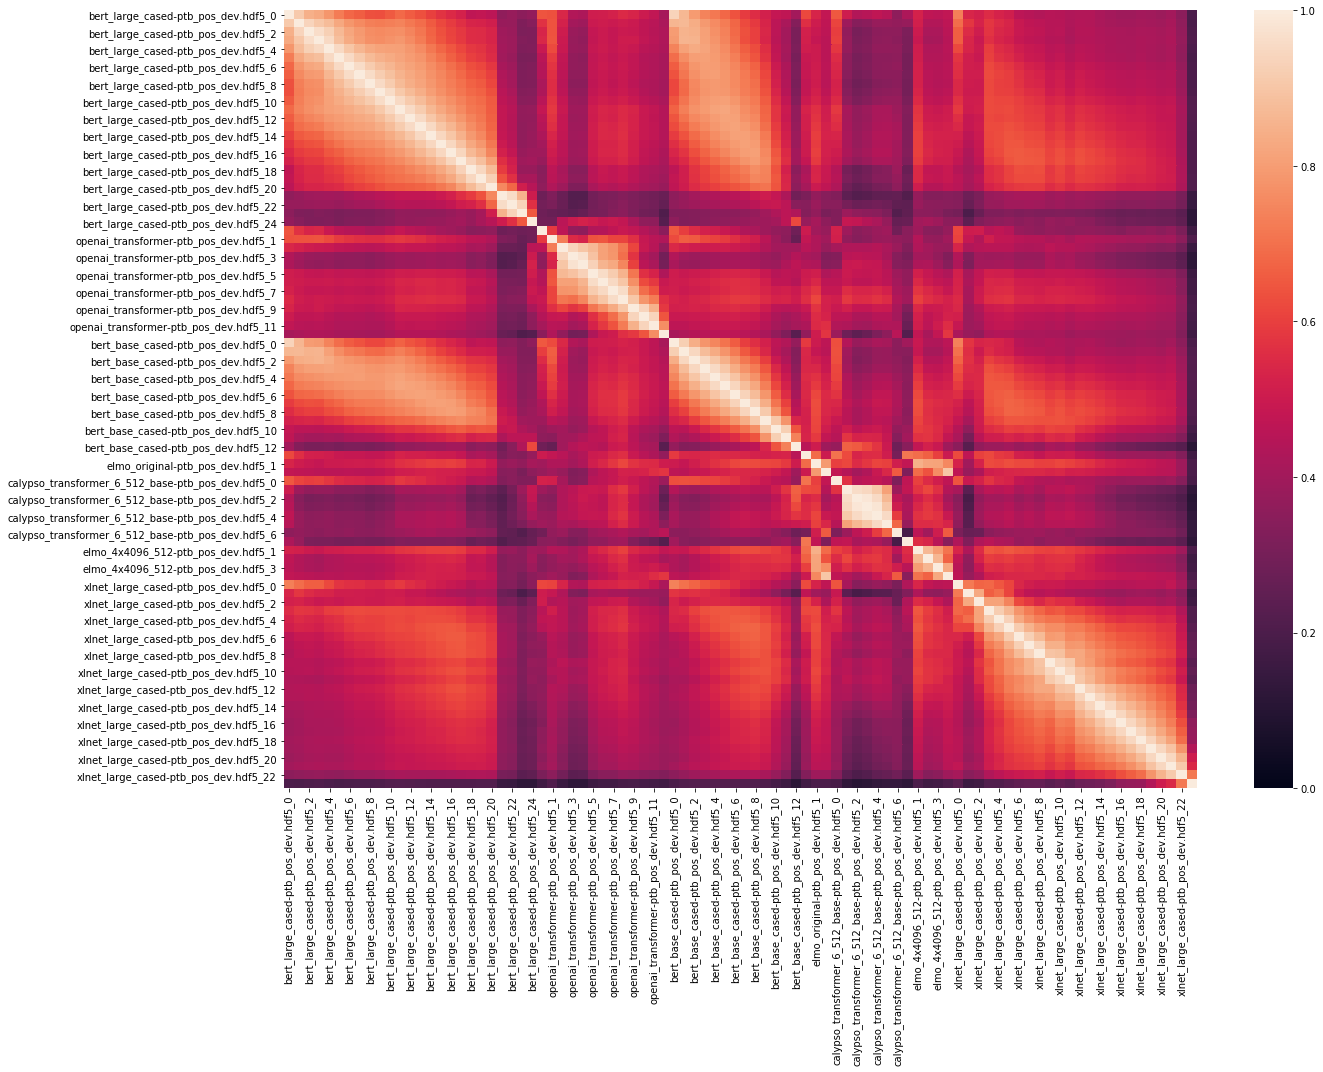

In [25]:
# lincka
fname_prefix = "temp_lincka8_1.00"
fname = "{0}.png".format(fname_prefix)
sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1)
plt.tight_layout()
plt.savefig(fname, transparent=True)

In [26]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.tight_layout()
        plt.savefig(fname, transparent=True)
        plt.show()

In [27]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_pw8_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [28]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_sv8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [29]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_maxmincorr8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [30]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_linregcorr8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [31]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [32]:
# comparing models
# use lincka
model1 = "elmo"
model2 = "elmo"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

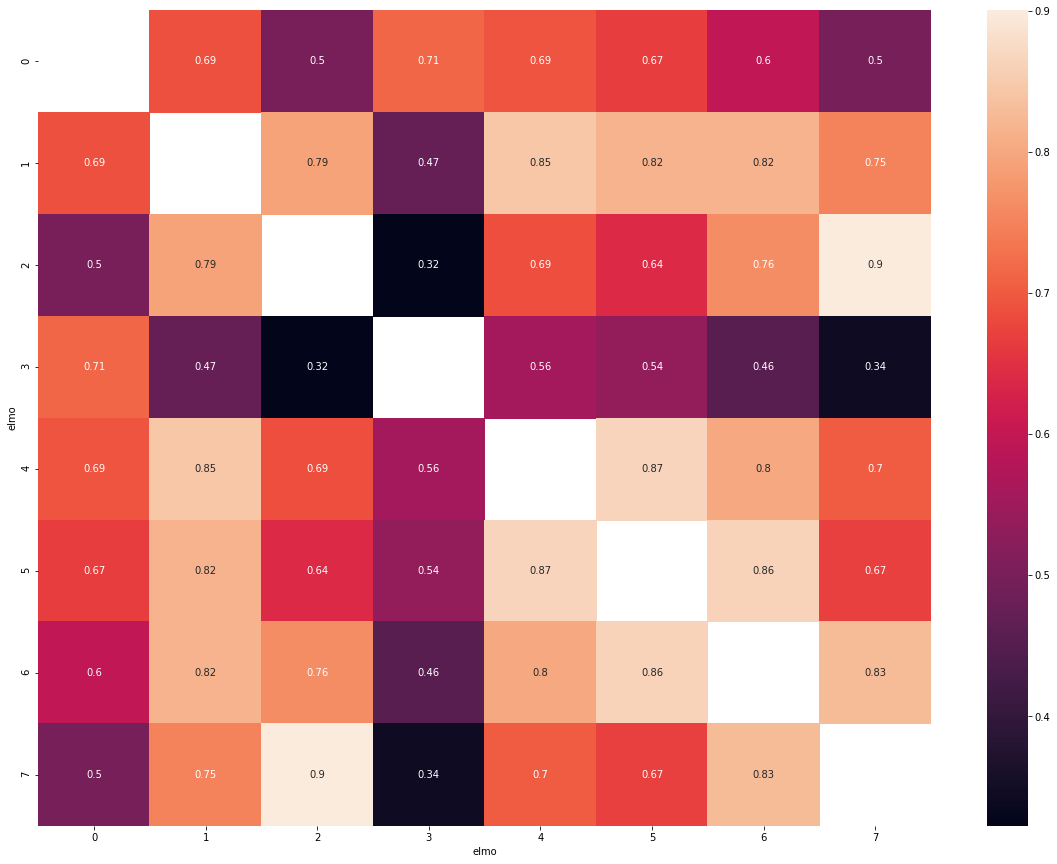

In [33]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()

# Localized vs distributed

In [34]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

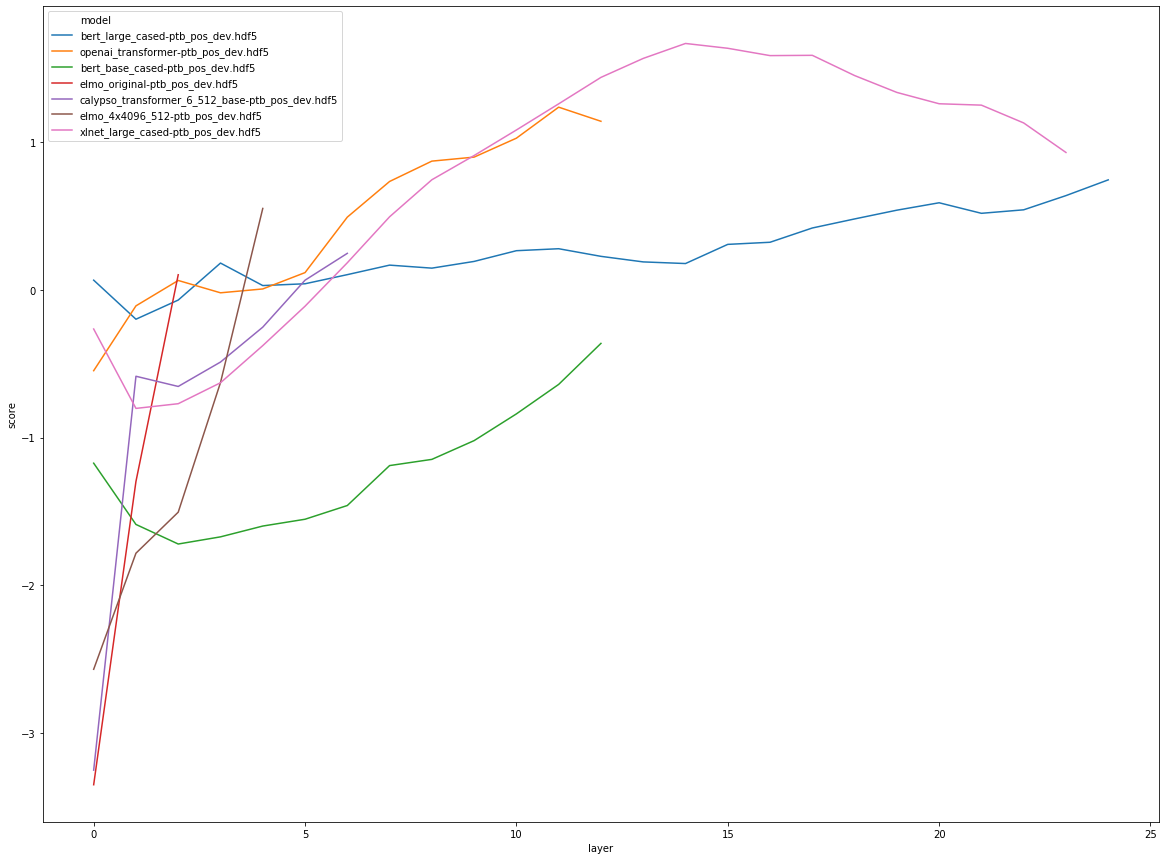

In [35]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
# print(models)
# print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
# diff_df.head()
sns.lineplot(data=diff_df, x='layer', y='score', hue='model')

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

elmo_original-ptb_pos_dev.hdf5_0                    -3.351387
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0   -3.252606
elmo_4x4096_512-ptb_pos_dev.hdf5_0                  -2.569540
elmo_4x4096_512-ptb_pos_dev.hdf5_1                  -1.783460
bert_base_cased-ptb_pos_dev.hdf5_2                  -1.721235
bert_base_cased-ptb_pos_dev.hdf5_3                  -1.672737
bert_base_cased-ptb_pos_dev.hdf5_4                  -1.599605
bert_base_cased-ptb_pos_dev.hdf5_1                  -1.588685
bert_base_cased-ptb_pos_dev.hdf5_5                  -1.553468
elmo_4x4096_512-ptb_pos_dev.hdf5_2                  -1.505604
bert_base_cased-ptb_pos_dev.hdf5_6                  -1.460482
elmo_original-ptb_pos_dev.hdf5_1                    -1.297594
bert_base_cased-ptb_pos_dev.hdf5_7                  -1.190058
bert_base_cased-ptb_pos_dev.hdf5_0                  -1.173818
bert_base_cased-ptb_pos_dev.hdf5_8                  -1.148047
bert_base_cased-ptb_pos_dev.hdf5_9                  -1.020965
bert_bas

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

elmo_original-ptb_pos_dev.hdf5_0                    -2.869944
elmo_4x4096_512-ptb_pos_dev.hdf5_2                  -2.563897
elmo_4x4096_512-ptb_pos_dev.hdf5_0                  -2.388023
elmo_4x4096_512-ptb_pos_dev.hdf5_3                  -2.304344
elmo_4x4096_512-ptb_pos_dev.hdf5_1                  -2.244064
elmo_original-ptb_pos_dev.hdf5_2                    -2.137721
elmo_original-ptb_pos_dev.hdf5_1                    -2.065791
elmo_4x4096_512-ptb_pos_dev.hdf5_4                  -1.933325
openai_transformer-ptb_pos_dev.hdf5_0               -1.604439
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0   -1.450946
xlnet_large_cased-ptb_pos_dev.hdf5_23               -1.359190
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6   -1.270144
openai_transformer-ptb_pos_dev.hdf5_12              -1.041802
bert_large_cased-ptb_pos_dev.hdf5_24                -0.992718
bert_base_cased-ptb_pos_dev.hdf5_12                 -0.983306
openai_transformer-ptb_pos_dev.hdf5_1               -0.587384
bert_bas

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

elmo_4x4096_512-ptb_pos_dev.hdf5_4                  -2.484545
xlnet_large_cased-ptb_pos_dev.hdf5_23               -2.289491
elmo_original-ptb_pos_dev.hdf5_2                    -2.239819
openai_transformer-ptb_pos_dev.hdf5_12              -2.183307
bert_large_cased-ptb_pos_dev.hdf5_24                -1.737499
elmo_4x4096_512-ptb_pos_dev.hdf5_3                  -1.676524
xlnet_large_cased-ptb_pos_dev.hdf5_22               -1.662539
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6   -1.517333
openai_transformer-ptb_pos_dev.hdf5_11              -1.448356
xlnet_large_cased-ptb_pos_dev.hdf5_21               -1.337818
bert_large_cased-ptb_pos_dev.hdf5_23                -1.183260
xlnet_large_cased-ptb_pos_dev.hdf5_20               -1.169744
elmo_4x4096_512-ptb_pos_dev.hdf5_2                  -1.058293
openai_transformer-ptb_pos_dev.hdf5_0               -1.056925
xlnet_large_cased-ptb_pos_dev.hdf5_19               -0.994617
openai_transformer-ptb_pos_dev.hdf5_10              -0.958329
xlnet_la